In [4]:
#run below code twice
from line_profiler import LineProfiler
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import plotnine as gg
import torch
# from acme.utils.loggers.terminal import TerminalLogger
import dataclasses
import chex
import haiku as hk
import jax
import jax.numpy as jnp
import optax
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import pipeline_l2_loss
import pipeline_var_l2_loss
import seaborn as sns
from dataloader import TabularDataset
from l2_loss import *

# Test our pipeline: changing var_recall to  var_l2_loss

training data count (251, 2)


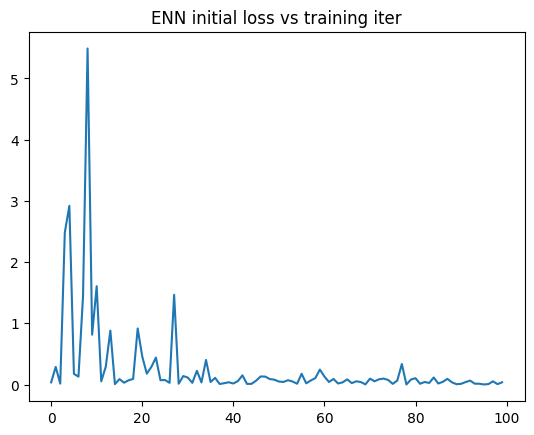

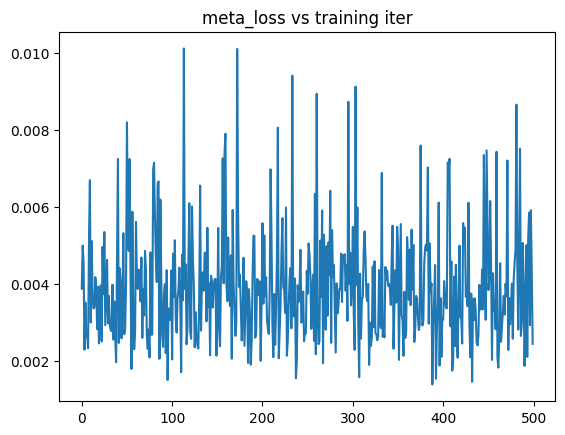

training epoch ends in  14.54 minutes.


In [ ]:
#data generated from https://github.com/dakshmittal30/Adaptive_sampling/blob/49060b32a7c95ab5f8057ff593629d64ea411c14/src/notebooks/Dataset_generator.ipynb
#predictor (a logistic regression) generated from https://github.com/dakshmittal30/Adaptive_sampling/blob/49060b32a7c95ab5f8057ff593629d64ea411c14/src/notebooks/Predictor.ipynb 
#biased data from https://github.com/dakshmittal30/Adaptive_sampling/blob/7cf3996c786ce33db90fcb7aef8584054169557c/src/notebooks/Selection_bias.ipynb 

##gradient check: https://colab.research.google.com/drive/1-NK2a0ctPmp6Uwozxr2317JyqfTC1nDF?authuser=1#scrollTo=kh9wxat3_hxT
##diff. GP: https://colab.research.google.com/drive/1WLcxbFuDcUhm7tm-073GNyLYWeIz_tDj?authuser=1 

directory = '/shared/share_mala/yuanzhe/adaptive_sampling/pipeline_datasets/'
train_csv_name = directory +'/biased_new/input_dim_1_train_init_data_mean_0.0ln_1.0sig_0.1no.2000_random_prop_score_selected_2_16.0__.csv'
test_csv_name = directory + 'input_dim_1_test_final_data_mean_0.0ln_1.0sig_0.1no.2000.csv'
pool_csv_name = directory + 'input_dim_1_pool_data_mean_0.0ln_1.0sig_0.1no.2000.csv'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

'''
data is from https://github.com/dakshmittal30/Adaptive_sampling/blob/b50b04706c8824d401d5cdb1c4dea9287cb9a2cb/src/notebooks/check_gradient/Selection_bias-regression.ipynb  
l2_loss train 0.0307949036359787
l2_loss test 0.07647431641817093
l2_loss pool 0.08316905051469803
'''

df_train = pd.read_csv(train_csv_name)
print('training data count',df_train.shape)

Z_dim = 8

dataset_cfg = pipeline_l2_loss.DatasetConfig(train_csv_name, test_csv_name, pool_csv_name, "EVENT_LABEL")
model_cfg = pipeline_l2_loss.ModelConfig(batch_size_train = 251, batch_size_test = 500, batch_size_query = 100, temp_k_subset = 0.1, hidden_sizes_weight_NN = [50,50], meta_opt_lr = 0.01, n_classes = 1, n_epoch = 5, init_train_lr = 0.05, init_train_weight_decay = 0.01, n_train_init = 100, meta_opt_weight_decay = 0.01)
train_cfg = pipeline_l2_loss.TrainConfig(n_train_iter = 500, n_ENN_iter = 15, ENN_opt_lr = 0.01, temp_var_recall = 0.4, z_dim = Z_dim, N_iter = 100, ENN_opt_weight_decay = 0.01) #temp_var_recall is the new variable added here
enn_cfg = pipeline_l2_loss.ENNConfig(basenet_hidden_sizes = [50,50],  exposed_layers = [False, True], z_dim = Z_dim, learnable_epinet_hiddens = [15,15], hidden_sizes_prior = [5,5], seed_base = 2, seed_learnable_epinet = 1, seed_prior_epinet = 0, alpha = 1.0)
 

model_predictor = torch.jit.load(directory + 'predictor_0214_regression.pt')
model_predictor.eval()

dataset_config = dataset_cfg
dataset_test = TabularDataset(device, csv_file=dataset_config.csv_file_test, y_column=dataset_config.y_column)

# Example usage pipeline_l2_loss.
res = pipeline_var_l2_loss.experiment(dataset_cfg, model_cfg, train_cfg, enn_cfg, model_predictor, device = device, if_print = 0)

In [ ]:
#jus l2 loss
res = pipeline_l2_loss.experiment(dataset_cfg, model_cfg, train_cfg, enn_cfg, model_predictor, device = device, if_print = 0)

In [3]:
#%load_ext line_profiler
#profiling code - check which part
#%reload_ext line_profiler

#%lprun -f experiment experiment(dataset_cfg, model_cfg, train_cfg, enn_cfg, model_predictor, if_print = 1)